# DDT QCD veto based on Autoencoder

In [118]:
import h5py
import numpy as np
import math

In [119]:
import matplotlib.pyplot as plt
plt.style.use('sonic.mplstyle')

## Define the threshold(Dijet Mass) function at fixed percentile

- we load the QCD sideband dataset
- we make a few plots for sanity check
- we run a quantile regression of $Loss(M_jj)$ at fixed percentile
- For each jet $i$, we cut on $Loss^i > Threshold(M_{jj}^i)$ 
- We verify that the accept ratio is comparable to the fixed quanntile

In [120]:
# read the sideband dataset
fileIN = h5py.File("../data/vae_mae/qcd_dEta_sideband_results.h5" "r")
rangeloss = (0., 1.)

In [121]:
list(fileIN.keys())

['labels', 'results']

In [122]:
labels = fileIN.get("labels")
print(labels[:])

[b'mJJ' b'j1Pt' b'j1Eta' b'j1Phi' b'j1M' b'j1E' b'j2Pt' b'j2M' b'j2E'
 b'DeltaEtaJJ' b'DeltaPhiJJ' b'j1Loss' b'j2Loss']


In [123]:
data = np.array(fileIN.get("results"))
print(data.shape)

(434282, 13)


In [124]:
# apply the dijet mass cut
highMjj = data[:,0] > 700.
data = data[highMjj,:]
print(data.shape)

(209109, 13)


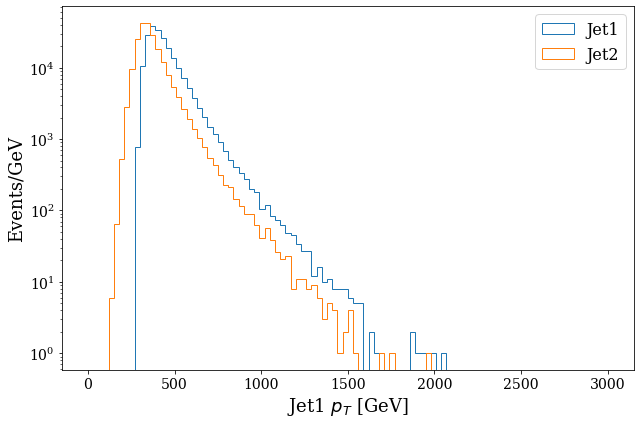

In [125]:
plt.figure(figsize=(9, 6))
plt.hist(data[:,1], range=(0.,3000.), bins=100, histtype='step', label = "Jet1")
plt.hist(data[:,6], range=(0.,3000.), bins=100, histtype='step', label = "Jet2")
plt.semilogy()
plt.xlabel("Jet1 $p_T$ [GeV]")
plt.ylabel("Events/GeV")
plt.legend()
plt.show()

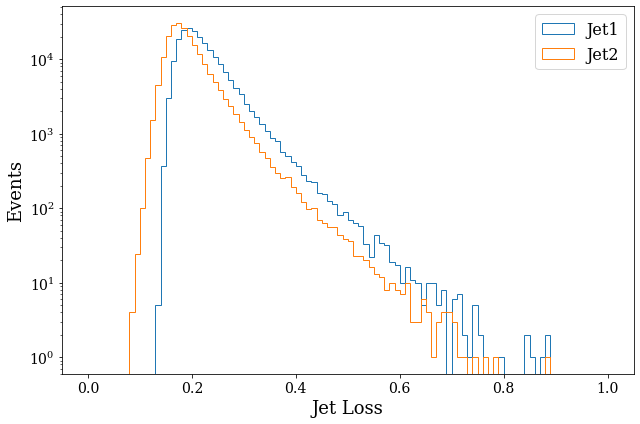

In [126]:
plt.figure(figsize=(9, 6))
plt.hist(data[:,-2], range=rangeloss, bins=100, histtype='step', label = "Jet1")
plt.hist(data[:,-1], range=rangeloss, bins=100, histtype='step', label = "Jet2")
plt.semilogy()
plt.xlabel("Jet Loss")
plt.ylabel("Events")
plt.legend()
plt.show()

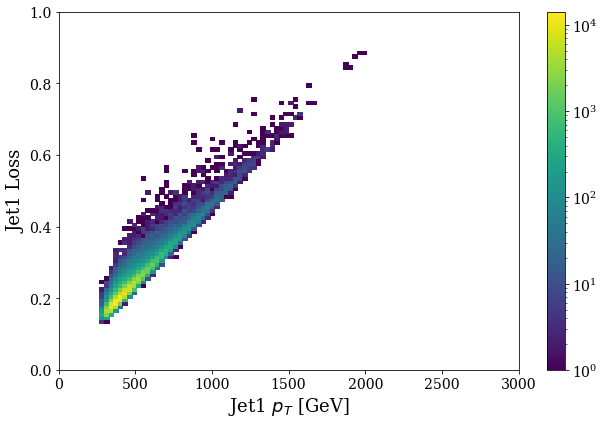

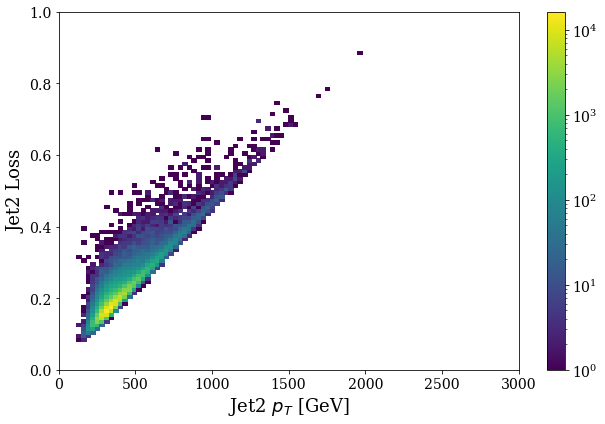

In [127]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,1], data[:,-2],range=((0.,3000.,),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet1 $p_T$ [GeV]")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,6], data[:,-1],range=((0.,3000.,),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet2 Loss")
plt.xlabel("Jet2 $p_T$ [GeV]")
plt.colorbar()
plt.draw()

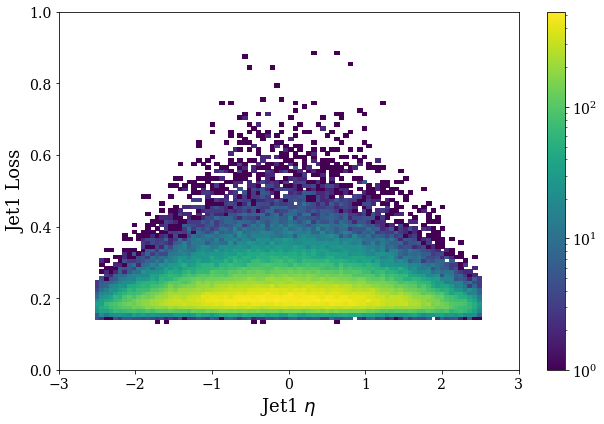

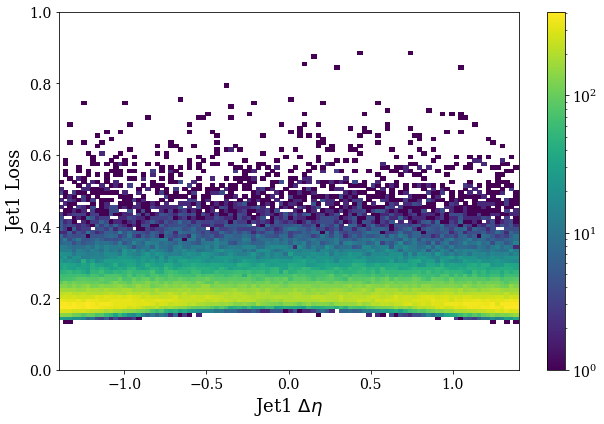

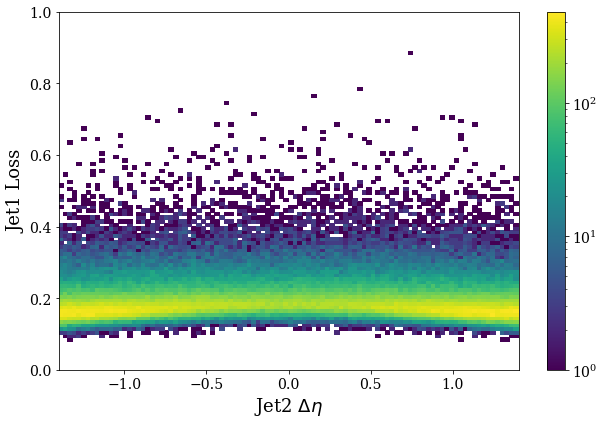

In [128]:
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,2], data[:,-2],range=((-3.,3.),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet1 $\eta$")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,9], data[:,-2],range=((-1.4,1.4),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet1 $\Delta\eta$")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,9], data[:,-1],range=((-1.4,1.4),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet2 $\Delta\eta$")
plt.colorbar()
plt.draw()

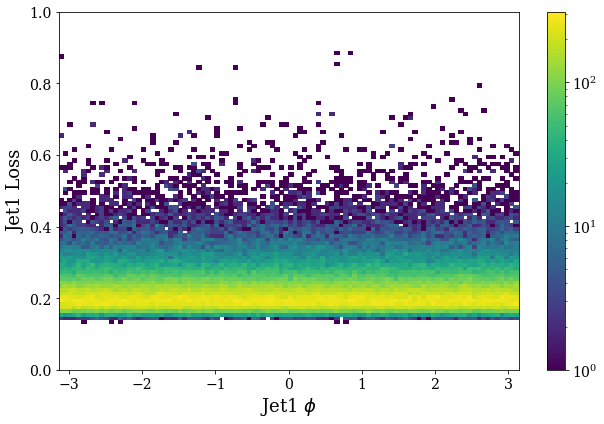

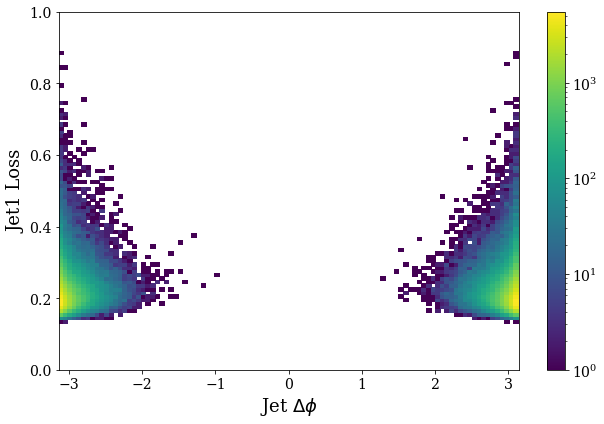

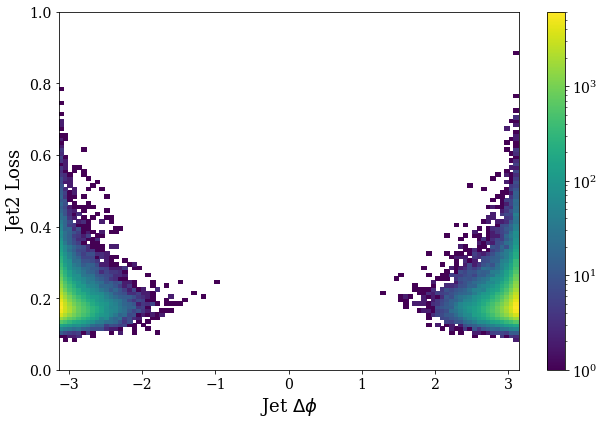

In [129]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,3], data[:,-2],range=((-3.142,3.142),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet1 $\phi$")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,10], data[:,-2],range=((-3.142,3.142),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet $\Delta\phi$")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,10], data[:,-1],range=((-3.142,3.142),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet2 Loss")
plt.xlabel("Jet $\Delta\phi$")
plt.colorbar()
plt.draw()

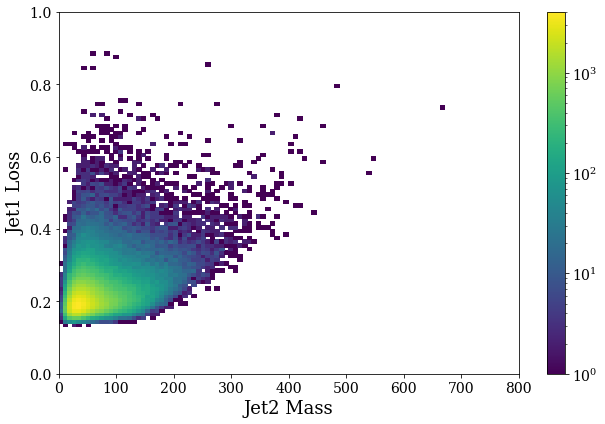

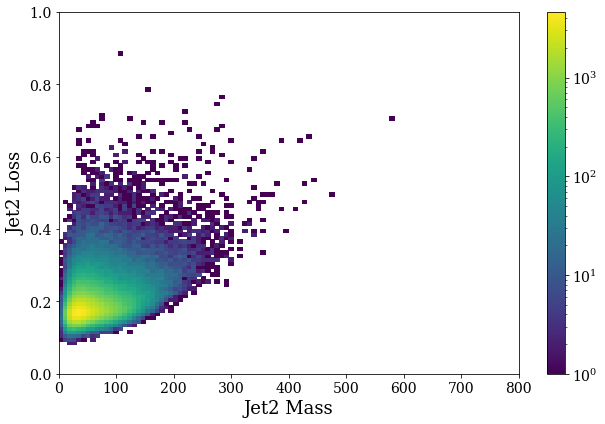

In [130]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,4], data[:,-2],range=((0.,800.),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1 Loss")
plt.xlabel("Jet2 Mass")
plt.colorbar()
plt.draw()
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,7], data[:,-1],range=((0.,800.),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet2 Loss")
plt.xlabel("Jet2 Mass")
plt.colorbar()
plt.draw()

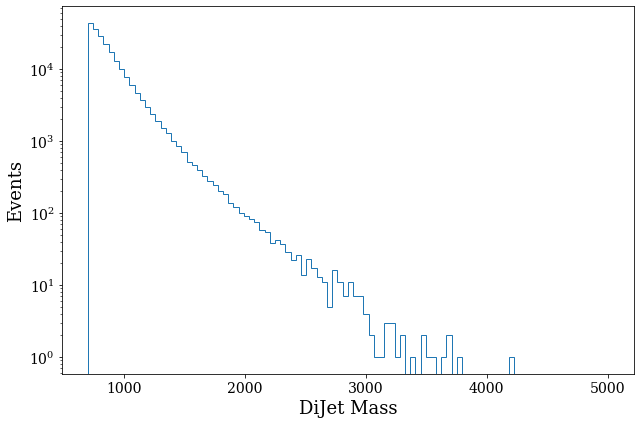

In [131]:
plt.figure(figsize=(9, 6))
plt.hist(data[:,0], range=(700.,5000.), bins=100, histtype='step')
plt.semilogy()
plt.xlabel("DiJet Mass")
plt.ylabel("Events")
plt.show()

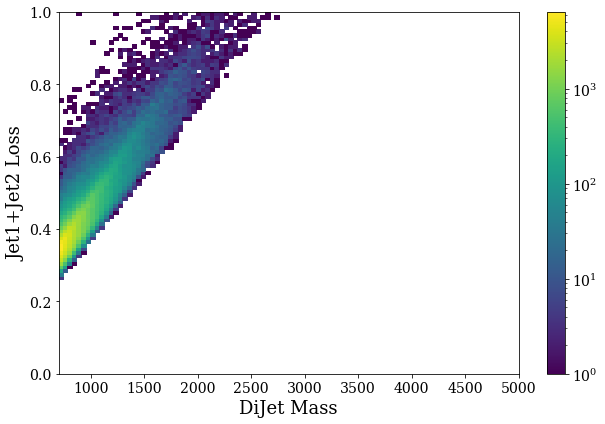

In [132]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(9, 6))
plt.hist2d(data[:,0], data[:,-2]+data[:,-1],range=((700.,5000.),rangeloss), norm=LogNorm(), bins=100)
plt.ylabel("Jet1+Jet2 Loss")
plt.xlabel("DiJet Mass")
plt.colorbar()
plt.draw()

In [133]:
# quantile regression
from sklearn.ensemble import GradientBoostingRegressor
x = np.reshape(data[:,0], (-1,1))
y = data[:,-1]+data[:,-2]
print(x.shape,y.shape)
alpha = 0.99
clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(x, y)

(209109, 1) (209109,)


GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='quantile', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [134]:
# separate the sample in iBin bins with comparable statistics
mjjVal = data[:,0]
mjjVal = np.sort(mjjVal)
iBin = 50
binStat = int(len(mjjVal)/iBin)
mjjBins = []
for i in range(iBin+1):
    mjjBins.append(int(mjjVal[i*binStat]))
mjjBins[-1] = max(mjjBins[-1], 5000.)
mjjBinMin = mjjBins[:-1]
mjjBinMax = mjjBins[1:]
print(mjjBinMin)
print(mjjBinMax)
mjjBinCenter = (np.array(mjjBinMin)+np.array(mjjBinMax))/2

[700, 703, 707, 711, 715, 719, 724, 728, 732, 736, 741, 745, 750, 755, 759, 764, 769, 774, 780, 785, 791, 796, 802, 809, 815, 822, 828, 836, 844, 851, 860, 869, 878, 888, 898, 910, 922, 936, 950, 966, 984, 1004, 1026, 1052, 1083, 1120, 1167, 1228, 1320, 1484]
[703, 707, 711, 715, 719, 724, 728, 732, 736, 741, 745, 750, 755, 759, 764, 769, 774, 780, 785, 791, 796, 802, 809, 815, 822, 828, 836, 844, 851, 860, 869, 878, 888, 898, 910, 922, 936, 950, 966, 984, 1004, 1026, 1052, 1083, 1120, 1167, 1228, 1320, 1484, 5000.0]


In [135]:
mJJval = data[:,0]
loss = data[:,-2]+data[:,-1]

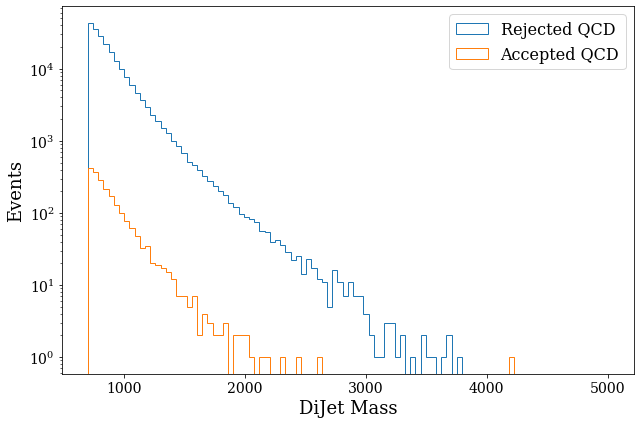

In [136]:
threshold_BDT = clf.predict(np.reshape(mJJval, (-1,1)))
mJJ_QCD_pass_BDT = mJJval[loss>=threshold_BDT]
mJJ_QCD_reject_BDT = mJJval[loss<threshold_BDT]
plt.figure(figsize=(9, 6))
plt.hist(mJJ_QCD_reject_BDT, range=(700.,5000.), bins=100, histtype='step', label="Rejected QCD")
plt.hist(mJJ_QCD_pass_BDT, range=(700.,5000.), bins=100, histtype='step', label="Accepted QCD")
plt.semilogy()
plt.xlabel("DiJet Mass")
plt.ylabel("Events")
plt.legend()
plt.show()

In [174]:
# equally spaced binning
mjjBinsEqual = np.linspace(700., 2500, num=50)
mjjBinsEqual =  np.concatenate((mjjBinsEqual, np.array([2500.,5000.])))
print(mjjBinsEqual)
mjjBinsEqualMin = mjjBinsEqual[:-1]
mjjBinsEqualMax = mjjBinsEqual[1:]
mjjBinsEqualCenter = (mjjBinsEqualMin+mjjBinsEqualMax)/2.

[ 700.          736.73469388  773.46938776  810.20408163  846.93877551
  883.67346939  920.40816327  957.14285714  993.87755102 1030.6122449
 1067.34693878 1104.08163265 1140.81632653 1177.55102041 1214.28571429
 1251.02040816 1287.75510204 1324.48979592 1361.2244898  1397.95918367
 1434.69387755 1471.42857143 1508.16326531 1544.89795918 1581.63265306
 1618.36734694 1655.10204082 1691.83673469 1728.57142857 1765.30612245
 1802.04081633 1838.7755102  1875.51020408 1912.24489796 1948.97959184
 1985.71428571 2022.44897959 2059.18367347 2095.91836735 2132.65306122
 2169.3877551  2206.12244898 2242.85714286 2279.59183673 2316.32653061
 2353.06122449 2389.79591837 2426.53061224 2463.26530612 2500.
 2500.         5000.        ]


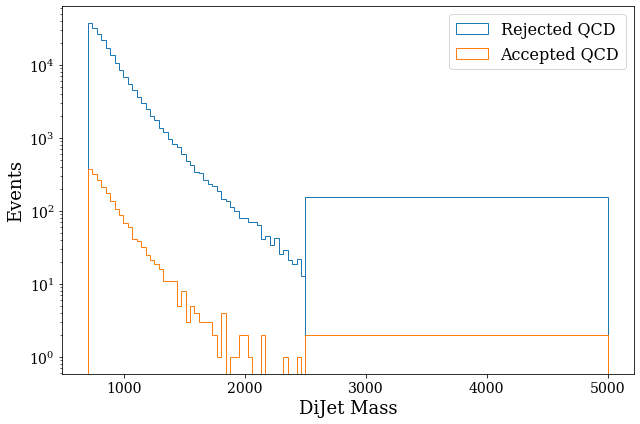

In [175]:
plt.figure(figsize=(9, 6))
hist_reject = plt.hist(mJJ_QCD_reject_BDT, range=(700.,5000.), bins=mjjBinsEqual, histtype='step', density=False, label="Rejected QCD")
hist_accept = plt.hist(mJJ_QCD_pass_BDT, range=(700.,5000.), bins=mjjBinsEqual, histtype='step', density=False, label="Accepted QCD")
plt.semilogy()
plt.xlabel("DiJet Mass")
plt.ylabel("Events")
plt.legend()
plt.show()

In [176]:
eff = np.array(hist_accept[0])/(np.array(hist_reject[0])+np.array(hist_accept[0]))
err = np.sqrt(eff*(1.-eff)/(hist_accept[0]+hist_reject[0]))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


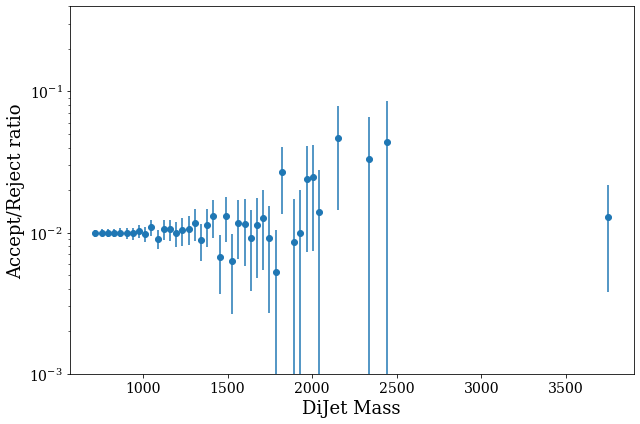

In [177]:
fig, ax = fig, ax = plt.subplots(figsize=(9, 6))
rejected = ax.errorbar(mjjBinsEqualCenter, eff, yerr=err, fmt='o')
ax.set_xlabel("DiJet Mass")
ax.set_ylabel("Accept/Reject ratio")
ax.semilogy()
ax.set_ylim((0.001, 0.4))
fig.show()

# Apply the selection to the signal region

Consider first the QCD-only background hypothesis
- apply the threshold requirement on $Loss_1+Loss_2$
- make the plot of the fraction of accepted events vs. mass 

In [178]:
# read the sideband dataset
fileIN = h5py.File("../data/vae_mae/qcd_dEta_signalregion_results.h5", "r")
data = np.array(fileIN.get("results"))
print(data.shape)

(979589, 13)


In [179]:
mJJval = data[:,0]
loss = data[:,-2]+data[:,-1]

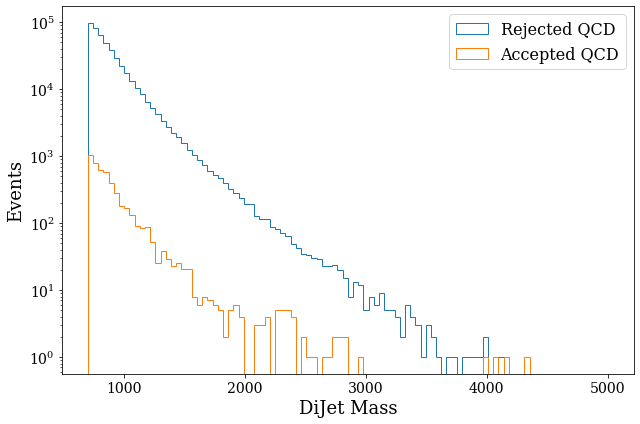

In [180]:
# apply the threshold to define accept and reject samples
threshold_BDT = clf.predict(np.reshape(mJJval, (-1,1)))
mJJ_QCD_pass_BDT = mJJval[loss>=threshold_BDT]
mJJ_QCD_reject_BDT = mJJval[loss<threshold_BDT]
plt.figure(figsize=(9, 6))
plt.hist(mJJ_QCD_reject_BDT, range=(700.,5000.), bins=100, histtype='step', label="Rejected QCD")
plt.hist(mJJ_QCD_pass_BDT, range=(700.,5000.), bins=100, histtype='step', label="Accepted QCD")
plt.semilogy()
plt.xlabel("DiJet Mass")
plt.ylabel("Events")
plt.legend()
plt.show()

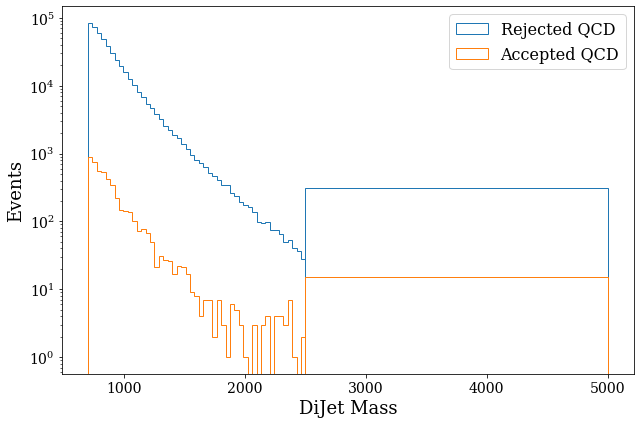

In [181]:
plt.figure(figsize=(9, 6))
hist_reject = plt.hist(mJJ_QCD_reject_BDT, range=(700.,5000.), bins=mjjBinsEqual, histtype='step', density=False, label="Rejected QCD")
hist_accept = plt.hist(mJJ_QCD_pass_BDT, range=(700.,5000.), bins=mjjBinsEqual, histtype='step', density=False, label="Accepted QCD")
plt.semilogy()
plt.xlabel("DiJet Mass")
plt.ylabel("Events")
plt.legend()
plt.show()

In [182]:
eff = np.array(hist_accept[0])/(np.array(hist_reject[0])+np.array(hist_accept[0]))
err = np.sqrt(eff*(1.-eff)/(hist_accept[0]+hist_reject[0]))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


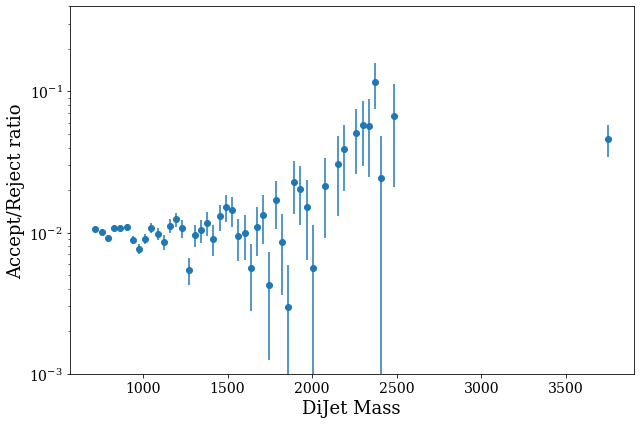

In [183]:
fig, ax = fig, ax = plt.subplots(figsize=(9, 6))
rejected = ax.errorbar(mjjBinsEqualCenter, eff, yerr=err, fmt='o')
ax.set_xlabel("DiJet Mass")
ax.set_ylabel("Accept/Reject ratio")
ax.semilogy()
ax.set_ylim((0.001, 0.4))
fig.show()